In [1]:
def run_esn_quantization(N, bit_width):
    import pandas as pd
    from reservoirpy.datasets import mackey_glass
    from reservoirpy.nodes import Reservoir, Ridge
    from reservoirpy.observables import rmse, rsquare, nrmse
    from brevitas.nn import QuantIdentity
    import numpy as np
    import torch
    from reservoirpy import Node
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error
    # Prepare Lorenz dataset

    sunspots_monthly = pd.read_csv('SN_m_tot_V2.0.csv',sep=';',header=None)
    sunspots_monthly.columns = ["year", "month", "fractionyear", "monthlymean", "monthlystd", "nobs", "definitive"]

    x = sunspots_monthly["fractionyear"].values
    y = sunspots_monthly["monthlymean"].values

    ### Normalize data
    scaler = MinMaxScaler()
    yscaled = scaler.fit_transform(y.reshape(-1,1))
    trainingfraction = 0.67
    train_len = int(len(yscaled) * trainingfraction)
    threshold_scale = 1.0 / (2 ** bit_width) 

    # Initialize and train ESN (FP32)
    reservoir = Reservoir(N, lr=1, sr=1, input_connectivity=0.3, rc_connectivity=0.2, input_scaling=1)
    readout = Ridge(ridge=1e-4)
    esn_model = reservoir >> readout
    esn_model = esn_model.fit(yscaled[:train_len], yscaled[1:train_len + 1], warmup=400)

    # Quantization helper
    def extract_Qinput(input_array, num_bits):
        quant_identity = QuantIdentity(return_quant_tensor=True, bit_width=num_bits)
        float_input = torch.tensor(input_array, dtype=torch.float64)
        quant_input = quant_identity(float_input)
        return (
            quant_input.int().detach().numpy(),
            quant_input.scale.detach().numpy(),
            quant_input.zero_point.detach().numpy()
        )

    # Extract quantized versions
    int_x, x_scale, _ = extract_Qinput(yscaled, num_bits=bit_width)
    int_Win, scale_Win, _ = extract_Qinput(esn_model.nodes[0].Win.todense(), num_bits=bit_width)
    int_Wr, scale_Wr, _ = extract_Qinput(esn_model.nodes[0].W.todense(), num_bits=bit_width)
    int_bias, _, _ = extract_Qinput(esn_model.nodes[0].bias.todense(), num_bits=bit_width)

    input_scale = (scale_Win * x_scale)
    reservoir_scale = (scale_Wr * threshold_scale)

    def compute_integer_thresholds(scale):
        return np.int32(-1 / scale), np.int32(1 / scale)

    a_scaled, b_scaled = compute_integer_thresholds(input_scale)
    c_scaled, d_scaled = compute_integer_thresholds(reservoir_scale)

    def piecewise_linear_hard_tanh_integer(x, a_scaled, b_scaled, div_scale):
        x = np.clip(x, a_scaled, b_scaled)
        x = x + b_scaled
        return (x / div_scale).astype(np.int32)

    div_scale = 2 ** bit_width

    def forward2(node: Node, x: np.ndarray) -> np.ndarray:
        state = node.state().astype(np.int64).reshape(1, N)
        r = state @ node.Wr.astype(np.int32)
        s = x @ node.Win.astype(np.int32).T
        s = s.reshape(1, N)
        out_r = piecewise_linear_hard_tanh_integer(s, a_scaled, b_scaled, div_scale)
        out_s = piecewise_linear_hard_tanh_integer(r, c_scaled, d_scaled, div_scale)
        return out_r + out_s + node.Bias.reshape(1, N)

    def initialize(node: Node, x: np.ndarray = None, y: np.ndarray = None):
        if x is not None:
            node.set_input_dim(x.shape[1])
            node.set_output_dim(N)
            node.set_param("Wr", int_Wr)
            node.set_param("Win", int_Win)
            node.set_param("Bias", int_bias)

    class CustomNode(Node):
        def __init__(self, name=None):
            super().__init__(
                forward=forward2,
                initializer=initialize,
                params={"Wr": None, "Win": None, "Bias": None},
                hypers={},
                name=name
            )

    node = CustomNode(name=f"quant_reservoir_N{N}_b{bit_width}")
    esn_model_PTQ = node >> readout

    Quantized_States = node.run(int_x[:train_len].astype(np.float64)) * threshold_scale
    readout.fit(Quantized_States, yscaled[1:train_len + 1], warmup=400)

    Quantized_States_test = node.run(int_x[train_len+1:-1].astype(np.float64)) * threshold_scale
    Y_pred_PTQ = readout.run(Quantized_States_test)

    # Evaluation
    a="R\u00B2"

    Y_true = yscaled[train_len + 2:]
    # min_x = np.min(Y_true)
    # max_x = np.max(Y_true)
    # min_pred = np.min(Y_pred_PTQ)
    # max_pred = np.max(Y_pred_PTQ)

    # predictions_int_normalized = (Y_pred_PTQ - min_pred) / (max_pred - min_pred) * (max_x - min_x) + min_x
    return {
        "N": N,
        "bits": bit_width,
        "RMSE": rmse(Y_true, Y_pred_PTQ),
        "NRMSE": nrmse(Y_true, Y_pred_PTQ),
        "R\u00B2": rsquare(Y_true, Y_pred_PTQ)
    }


In [2]:
def run_esn_float(N):
    import pandas as pd
    from reservoirpy.datasets import lorenz
    from reservoirpy.nodes import Reservoir, Ridge
    from reservoirpy.observables import rmse, rsquare, nrmse
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error

    sunspots_monthly = pd.read_csv('SN_m_tot_V2.0.csv',sep=';',header=None)
    sunspots_monthly.columns = ["year", "month", "fractionyear", "monthlymean", "monthlystd", "nobs", "definitive"]

    x = sunspots_monthly["fractionyear"].values
    y = sunspots_monthly["monthlymean"].values
    ### Normalize data
    scaler = MinMaxScaler()
    yscaled = scaler.fit_transform(y.reshape(-1,1))

    trainingfraction = 0.67
    train_len = int(len(yscaled) * trainingfraction)


    reservoir = Reservoir(N, lr=1, sr=1, input_connectivity=0.3, rc_connectivity=0.2, input_scaling=1)
    readout = Ridge(ridge=1e-4)
    esn_model = reservoir >> readout
    esn_model = esn_model.fit(yscaled[:train_len], yscaled[1:train_len + 1], warmup=400)

    Y_pred = esn_model.run(yscaled[train_len+1:-1])
    Y_true = yscaled[train_len + 2:]


    return {
        "N": N,
        "bits": "FP",
        "RMSE": rmse(Y_true, Y_pred),
        "NRMSE": nrmse(Y_true, Y_pred),
        "R\u00B2": rsquare(Y_true, Y_pred)
    }


In [3]:
# Define parameter sets
N_list = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bit_width_list = [4, 6, 8,16]

results = []

# Step 1: Run float (baseline) for each N
for N in N_list:
    print(f"Running float (FP32) evaluation for N={N}...")
    float_result = run_esn_float(N)
    results.append(float_result)

# Step 2: Run quantized evaluations
for N in N_list:
    for bits in bit_width_list:
        print(f"Running quantized evaluation for N={N}, bit_width={bits}...")
        quant_result = run_esn_quantization(N, bits)
        results.append(quant_result)

# Step 3: Create DataFrame and save
import pandas as pd

df_results = pd.DataFrame(results)
print(df_results)

# Optional: Save to CSV
df_results.to_csv("quantized_and_float_esn_results.csv", index=False)


Running float (FP32) evaluation for N=50...


Running Model-0: 2172it [00:00, 18437.88it/s]?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


Fitting node Ridge-0...


Running Model-0: 1068it [00:00, 20326.79it/s]         


Running float (FP32) evaluation for N=100...


Running Model-1: 2172it [00:00, 17758.65it/s]?, ?it/s]
Running Model-1: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


Fitting node Ridge-1...


Running Model-1: 1068it [00:00, 15559.60it/s]         


Running float (FP32) evaluation for N=150...


Running Model-2: 2172it [00:00, 17159.79it/s]?, ?it/s]
Running Model-2: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Fitting node Ridge-2...


Running Model-2: 1068it [00:00, 14311.23it/s]         


Running float (FP32) evaluation for N=200...


Running Model-3: 2172it [00:00, 17340.84it/s]?, ?it/s]
Running Model-3: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


Fitting node Ridge-3...


Running Model-3: 1068it [00:00, 14000.15it/s]         


Running float (FP32) evaluation for N=250...


Running Model-4: 2172it [00:00, 16247.02it/s]?, ?it/s]
Running Model-4: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


Fitting node Ridge-4...


Running Model-4: 1068it [00:00, 13747.05it/s]         


Running float (FP32) evaluation for N=300...


Running Model-5: 2172it [00:00, 15738.37it/s]?, ?it/s]
Running Model-5: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Fitting node Ridge-5...


Running Model-5: 1068it [00:00, 13190.84it/s]         


Running float (FP32) evaluation for N=350...


Running Model-6: 2172it [00:00, 15093.05it/s]?, ?it/s]
Running Model-6: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


Fitting node Ridge-6...


Running Model-6: 1068it [00:00, 10542.27it/s]         


Running float (FP32) evaluation for N=400...


Running Model-7: 2172it [00:00, 14821.32it/s]?, ?it/s]
Running Model-7: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]


Fitting node Ridge-7...


Running Model-7: 1068it [00:00, 12724.45it/s]         


Running float (FP32) evaluation for N=450...


Running Model-8: 2172it [00:00, 13786.40it/s]?, ?it/s]
Running Model-8: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


Fitting node Ridge-8...


Running Model-8: 1068it [00:00, 9933.49it/s]          


Running float (FP32) evaluation for N=500...


Running Model-9: 2172it [00:00, 13278.82it/s]?, ?it/s]
Running Model-9: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


Fitting node Ridge-9...


Running Model-9: 1068it [00:00, 11727.86it/s]         


Running quantized evaluation for N=50, bit_width=4...


Running Model-10: 2172it [00:00, 17904.58it/s]?, ?it/s]
Running Model-10: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]
/home/atousa/.local/lib/python3.10/site-packages/torch/_tensor.py:1644: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /pytorch/c10/core/TensorImpl.h:1935.)
  return super().rename(names)


Fitting node Ridge-10...


Running Ridge-10: 100%|██████████| 1068/1068 [00:00<00:00, 144226.04it/s]


Running quantized evaluation for N=50, bit_width=6...


Running Model-12: 2172it [00:00, 17786.91it/s]?, ?it/s]
Running Model-12: 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


Fitting node Ridge-11...


Running Ridge-11: 100%|██████████| 1068/1068 [00:00<00:00, 140494.19it/s]


Running quantized evaluation for N=50, bit_width=8...


Running Model-14: 2172it [00:00, 18296.06it/s]?, ?it/s]
Running Model-14: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Fitting node Ridge-12...


Running Ridge-12: 100%|██████████| 1068/1068 [00:00<00:00, 133089.21it/s]


Running quantized evaluation for N=50, bit_width=16...


Running Model-16: 2172it [00:00, 17577.02it/s]?, ?it/s]
Running Model-16: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


Fitting node Ridge-13...


Running Ridge-13: 100%|██████████| 1068/1068 [00:00<00:00, 136938.02it/s]


Running quantized evaluation for N=100, bit_width=4...


Running Model-18: 2172it [00:00, 17174.25it/s]?, ?it/s]
Running Model-18: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Fitting node Ridge-14...


Running Ridge-14: 100%|██████████| 1068/1068 [00:00<00:00, 137704.17it/s]


Running quantized evaluation for N=100, bit_width=6...


Running Model-20: 2172it [00:00, 17424.22it/s]?, ?it/s]
Running Model-20: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


Fitting node Ridge-15...


Running Ridge-15: 100%|██████████| 1068/1068 [00:00<00:00, 132923.34it/s]


Running quantized evaluation for N=100, bit_width=8...


Running Model-22: 2172it [00:00, 18270.41it/s]?, ?it/s]
Running Model-22: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


Fitting node Ridge-16...


Running Ridge-16: 100%|██████████| 1068/1068 [00:00<00:00, 136963.15it/s]


Running quantized evaluation for N=100, bit_width=16...


Running Model-24: 2172it [00:00, 17831.79it/s]?, ?it/s]
Running Model-24: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Fitting node Ridge-17...


/tmp/ipykernel_3460935/338523662.py:54: RuntimeWarning: invalid value encountered in cast
  return np.int32(-1 / scale), np.int32(1 / scale)
Running Ridge-17: 100%|██████████| 1068/1068 [00:00<00:00, 141635.84it/s]


Running quantized evaluation for N=150, bit_width=4...


Running Model-26: 2172it [00:00, 17388.20it/s]?, ?it/s]
Running Model-26: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


Fitting node Ridge-18...


Running Ridge-18: 100%|██████████| 1068/1068 [00:00<00:00, 139331.78it/s]


Running quantized evaluation for N=150, bit_width=6...


Running Model-28: 2172it [00:00, 17483.61it/s]?, ?it/s]
Running Model-28: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


Fitting node Ridge-19...


Running Ridge-19: 100%|██████████| 1068/1068 [00:00<00:00, 128695.86it/s]


Running quantized evaluation for N=150, bit_width=8...


Running Model-30: 2172it [00:00, 16659.68it/s]?, ?it/s]
Running Model-30: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


Fitting node Ridge-20...


Running Ridge-20: 100%|██████████| 1068/1068 [00:00<00:00, 85200.79it/s]


Running quantized evaluation for N=150, bit_width=16...


Running Model-32: 2172it [00:00, 16297.27it/s]?, ?it/s]
Running Model-32: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Fitting node Ridge-21...


/tmp/ipykernel_3460935/338523662.py:54: RuntimeWarning: invalid value encountered in cast
  return np.int32(-1 / scale), np.int32(1 / scale)
Running Ridge-21: 100%|██████████| 1068/1068 [00:00<00:00, 86930.27it/s]


Running quantized evaluation for N=200, bit_width=4...


Running Model-34: 2172it [00:00, 16961.48it/s]?, ?it/s]
Running Model-34: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


Fitting node Ridge-22...


Running Ridge-22: 100%|██████████| 1068/1068 [00:00<00:00, 140648.58it/s]


Running quantized evaluation for N=200, bit_width=6...


Running Model-36: 2172it [00:00, 17101.68it/s]?, ?it/s]
Running Model-36: 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


Fitting node Ridge-23...


Running Ridge-23: 100%|██████████| 1068/1068 [00:00<00:00, 129822.25it/s]


Running quantized evaluation for N=200, bit_width=8...


Running Model-38: 2172it [00:00, 16725.04it/s]?, ?it/s]
Running Model-38: 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


Fitting node Ridge-24...


Running Ridge-24: 100%|██████████| 1068/1068 [00:00<00:00, 82179.40it/s]


Running quantized evaluation for N=200, bit_width=16...


Running Model-40: 2172it [00:00, 16853.32it/s]?, ?it/s]
Running Model-40: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


Fitting node Ridge-25...


/tmp/ipykernel_3460935/338523662.py:54: RuntimeWarning: invalid value encountered in cast
  return np.int32(-1 / scale), np.int32(1 / scale)
Running Ridge-25: 100%|██████████| 1068/1068 [00:00<00:00, 139141.35it/s]


Running quantized evaluation for N=250, bit_width=4...


Running Model-42: 2172it [00:00, 16618.01it/s]?, ?it/s]
Running Model-42: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


Fitting node Ridge-26...


Running Ridge-26: 100%|██████████| 1068/1068 [00:00<00:00, 125871.55it/s]


Running quantized evaluation for N=250, bit_width=6...


Running Model-44: 2172it [00:00, 16102.91it/s]?, ?it/s]
Running Model-44: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


Fitting node Ridge-27...


Running Ridge-27: 100%|██████████| 1068/1068 [00:00<00:00, 136595.62it/s]


Running quantized evaluation for N=250, bit_width=8...


Running Model-46: 2172it [00:00, 16479.79it/s]?, ?it/s]
Running Model-46: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


Fitting node Ridge-28...


Running Ridge-28: 100%|██████████| 1068/1068 [00:00<00:00, 142161.75it/s]


Running quantized evaluation for N=250, bit_width=16...


Running Model-48: 2172it [00:00, 16493.87it/s]?, ?it/s]
Running Model-48: 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


Fitting node Ridge-29...


/tmp/ipykernel_3460935/338523662.py:54: RuntimeWarning: invalid value encountered in cast
  return np.int32(-1 / scale), np.int32(1 / scale)
Running Ridge-29: 100%|██████████| 1068/1068 [00:00<00:00, 131310.21it/s]


Running quantized evaluation for N=300, bit_width=4...


Running Model-50: 2172it [00:00, 15960.78it/s]?, ?it/s]
Running Model-50: 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


Fitting node Ridge-30...


Running Ridge-30: 100%|██████████| 1068/1068 [00:00<00:00, 134077.12it/s]


Running quantized evaluation for N=300, bit_width=6...


Running Model-52: 2172it [00:00, 16073.36it/s]?, ?it/s]
Running Model-52: 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


Fitting node Ridge-31...


Running Ridge-31: 100%|██████████| 1068/1068 [00:00<00:00, 138307.91it/s]


Running quantized evaluation for N=300, bit_width=8...


Running Model-54: 2172it [00:00, 15955.94it/s]?, ?it/s]
Running Model-54: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


Fitting node Ridge-32...


Running Ridge-32: 100%|██████████| 1068/1068 [00:00<00:00, 134085.15it/s]


Running quantized evaluation for N=300, bit_width=16...


Running Model-56: 2172it [00:00, 15864.86it/s]?, ?it/s]
Running Model-56: 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


Fitting node Ridge-33...


/tmp/ipykernel_3460935/338523662.py:54: RuntimeWarning: invalid value encountered in cast
  return np.int32(-1 / scale), np.int32(1 / scale)
Running Ridge-33: 100%|██████████| 1068/1068 [00:00<00:00, 139718.56it/s]


Running quantized evaluation for N=350, bit_width=4...


Running Model-58: 2172it [00:00, 15305.11it/s]?, ?it/s]
Running Model-58: 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


Fitting node Ridge-34...


Running Ridge-34: 100%|██████████| 1068/1068 [00:00<00:00, 135087.96it/s]


Running quantized evaluation for N=350, bit_width=6...


Running Model-60: 2172it [00:00, 15335.25it/s]?, ?it/s]
Running Model-60: 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


Fitting node Ridge-35...


Running Ridge-35: 100%|██████████| 1068/1068 [00:00<00:00, 136035.61it/s]


Running quantized evaluation for N=350, bit_width=8...


Running Model-62: 2172it [00:00, 15603.83it/s]?, ?it/s]
Running Model-62: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Fitting node Ridge-36...


Running Ridge-36: 100%|██████████| 1068/1068 [00:00<00:00, 134129.31it/s]


Running quantized evaluation for N=350, bit_width=16...


Running Model-64: 2172it [00:00, 15650.12it/s]?, ?it/s]
Running Model-64: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Fitting node Ridge-37...


/tmp/ipykernel_3460935/338523662.py:54: RuntimeWarning: invalid value encountered in cast
  return np.int32(-1 / scale), np.int32(1 / scale)
Running Ridge-37: 100%|██████████| 1068/1068 [00:00<00:00, 134028.98it/s]


Running quantized evaluation for N=400, bit_width=4...


Running Model-66: 2172it [00:00, 14842.57it/s]?, ?it/s]
Running Model-66: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


Fitting node Ridge-38...


Running Ridge-38: 100%|██████████| 1068/1068 [00:00<00:00, 135287.87it/s]


Running quantized evaluation for N=400, bit_width=6...


Running Model-68: 2172it [00:00, 14568.31it/s]?, ?it/s]
Running Model-68: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]


Fitting node Ridge-39...


Running Ridge-39: 100%|██████████| 1068/1068 [00:00<00:00, 132299.14it/s]


Running quantized evaluation for N=400, bit_width=8...


Running Model-70: 2172it [00:00, 14770.02it/s]?, ?it/s]
Running Model-70: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


Fitting node Ridge-40...


Running Ridge-40: 100%|██████████| 1068/1068 [00:00<00:00, 127516.20it/s]


Running quantized evaluation for N=400, bit_width=16...


Running Model-72: 2172it [00:00, 14674.04it/s]?, ?it/s]
Running Model-72: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]


Fitting node Ridge-41...


/tmp/ipykernel_3460935/338523662.py:54: RuntimeWarning: invalid value encountered in cast
  return np.int32(-1 / scale), np.int32(1 / scale)
Running Ridge-41: 100%|██████████| 1068/1068 [00:00<00:00, 136271.50it/s]


Running quantized evaluation for N=450, bit_width=4...


Running Model-74: 2172it [00:00, 13943.31it/s]?, ?it/s]
Running Model-74: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


Fitting node Ridge-42...


Running Ridge-42: 100%|██████████| 1068/1068 [00:00<00:00, 101960.14it/s]


Running quantized evaluation for N=450, bit_width=6...


Running Model-76: 2172it [00:00, 14361.07it/s]?, ?it/s]
Running Model-76: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]


Fitting node Ridge-43...


Running Ridge-43: 100%|██████████| 1068/1068 [00:00<00:00, 124148.24it/s]


Running quantized evaluation for N=450, bit_width=8...


Running Model-78: 2172it [00:00, 14170.08it/s]?, ?it/s]
Running Model-78: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


Fitting node Ridge-44...


Running Ridge-44: 100%|██████████| 1068/1068 [00:00<00:00, 130934.08it/s]


Running quantized evaluation for N=450, bit_width=16...


Running Model-80: 2172it [00:00, 14218.58it/s]?, ?it/s]
Running Model-80: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]


Fitting node Ridge-45...


/tmp/ipykernel_3460935/338523662.py:54: RuntimeWarning: invalid value encountered in cast
  return np.int32(-1 / scale), np.int32(1 / scale)
Running Ridge-45: 100%|██████████| 1068/1068 [00:00<00:00, 129750.80it/s]


Running quantized evaluation for N=500, bit_width=4...


Running Model-82: 2172it [00:00, 12899.01it/s]?, ?it/s]
Running Model-82: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Fitting node Ridge-46...


Running Ridge-46: 100%|██████████| 1068/1068 [00:00<00:00, 139496.66it/s]


Running quantized evaluation for N=500, bit_width=6...


Running Model-84: 2172it [00:00, 13556.13it/s]?, ?it/s]
Running Model-84: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


Fitting node Ridge-47...


Running Ridge-47: 100%|██████████| 1068/1068 [00:00<00:00, 139011.81it/s]


Running quantized evaluation for N=500, bit_width=8...


Running Model-86: 2172it [00:00, 13224.64it/s]?, ?it/s]
Running Model-86: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Fitting node Ridge-48...


Running Ridge-48: 100%|██████████| 1068/1068 [00:00<00:00, 127136.19it/s]


Running quantized evaluation for N=500, bit_width=16...


Running Model-88: 2172it [00:00, 12828.39it/s]?, ?it/s]
Running Model-88: 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Fitting node Ridge-49...


/tmp/ipykernel_3460935/338523662.py:54: RuntimeWarning: invalid value encountered in cast
  return np.int32(-1 / scale), np.int32(1 / scale)
Running Ridge-49: 100%|██████████| 1068/1068 [00:00<00:00, 142148.21it/s]

      N bits      RMSE     NRMSE        R²
0    50   FP  0.063241  0.070068  0.887413
1   100   FP  0.065742  0.072839  0.878332
2   150   FP  0.064555  0.071525  0.882683
3   200   FP  0.066925  0.074150  0.873912
4   250   FP  0.065812  0.072917  0.878073
5   300   FP  0.066849  0.074066  0.874199
6   350   FP  0.070070  0.077635  0.861783
7   400   FP  0.068787  0.076213  0.866797
8   450   FP  0.068532  0.075931  0.867784
9   500   FP  0.073622  0.081570  0.847416
10   50    4  0.078588  0.087072  0.826138
11   50    6  0.064578  0.071550  0.882601
12   50    8  0.064058  0.070974  0.884482
13   50   16  0.062580  0.069336  0.889752
14  100    4  0.077375  0.085728  0.831462
15  100    6  0.064664  0.071645  0.882287
16  100    8  0.063637  0.070508  0.885996
17  100   16  0.066471  0.073647  0.875617
18  150    4  0.078015  0.086437  0.828664
19  150    6  0.066739  0.073944  0.874613
20  150    8  0.064282  0.071222  0.883674
21  150   16  0.066471  0.073647  0.875617
22  200    

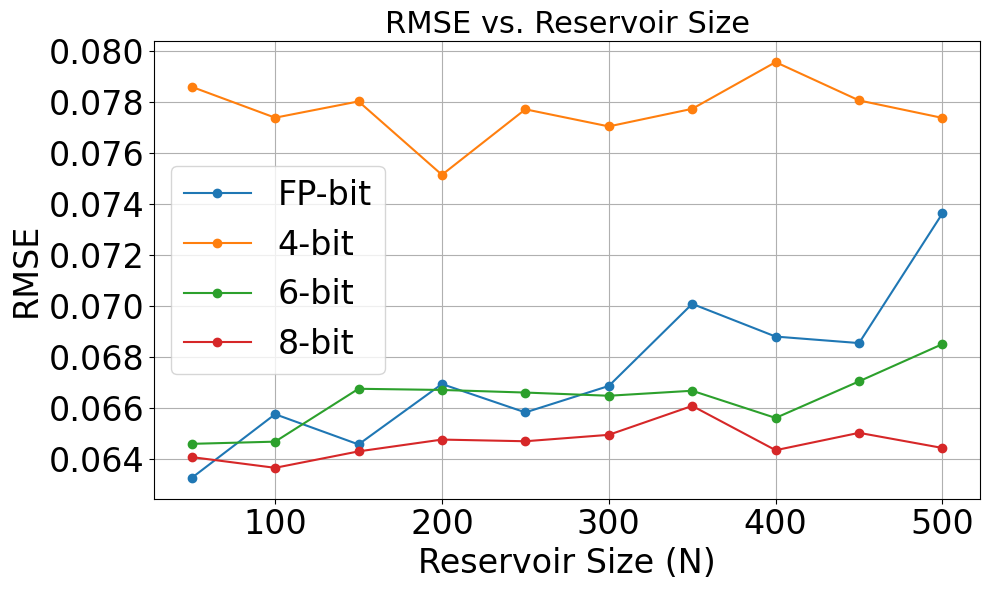

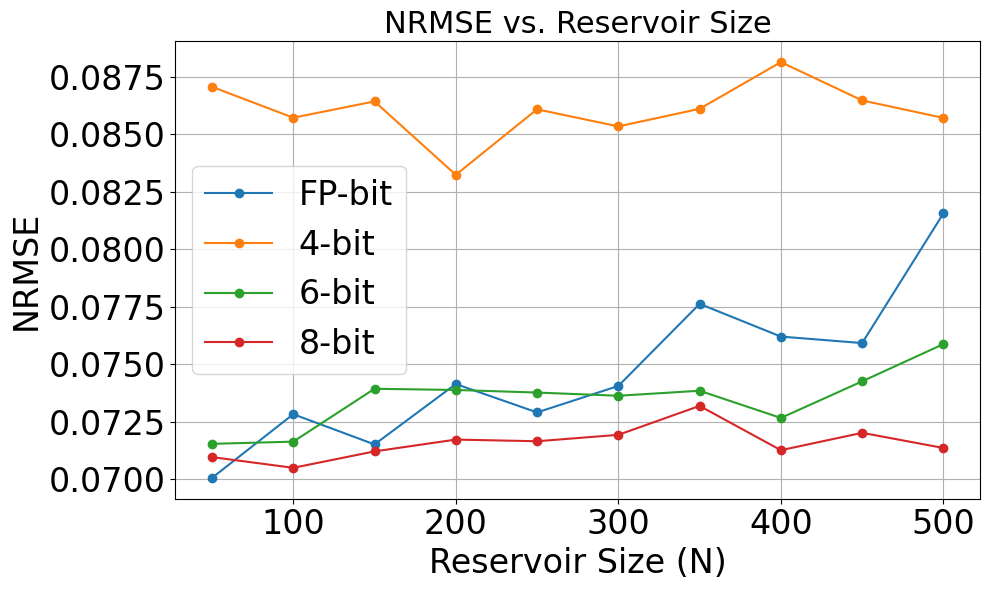

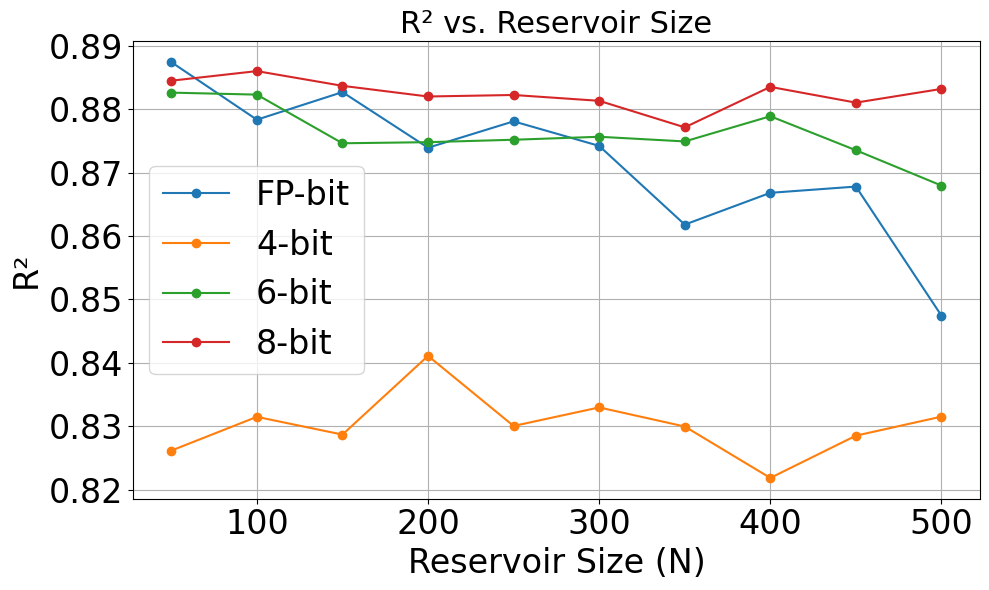

In [4]:
import matplotlib.pyplot as plt

for metric in ['RMSE', 'NRMSE', 'R\u00B2']:
    plt.figure(figsize=(10, 6))
    for bits in ['FP', 4, 6, 8]:
        subset = df_results[df_results['bits'] == bits]
        plt.plot(subset['N'], subset[metric], marker='o', label=f"{bits}-bit")

    plt.title(f"{metric} vs. Reservoir Size", fontsize=22)
    plt.xlabel("Reservoir Size (N)", fontsize=24)
    plt.ylabel(metric, fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


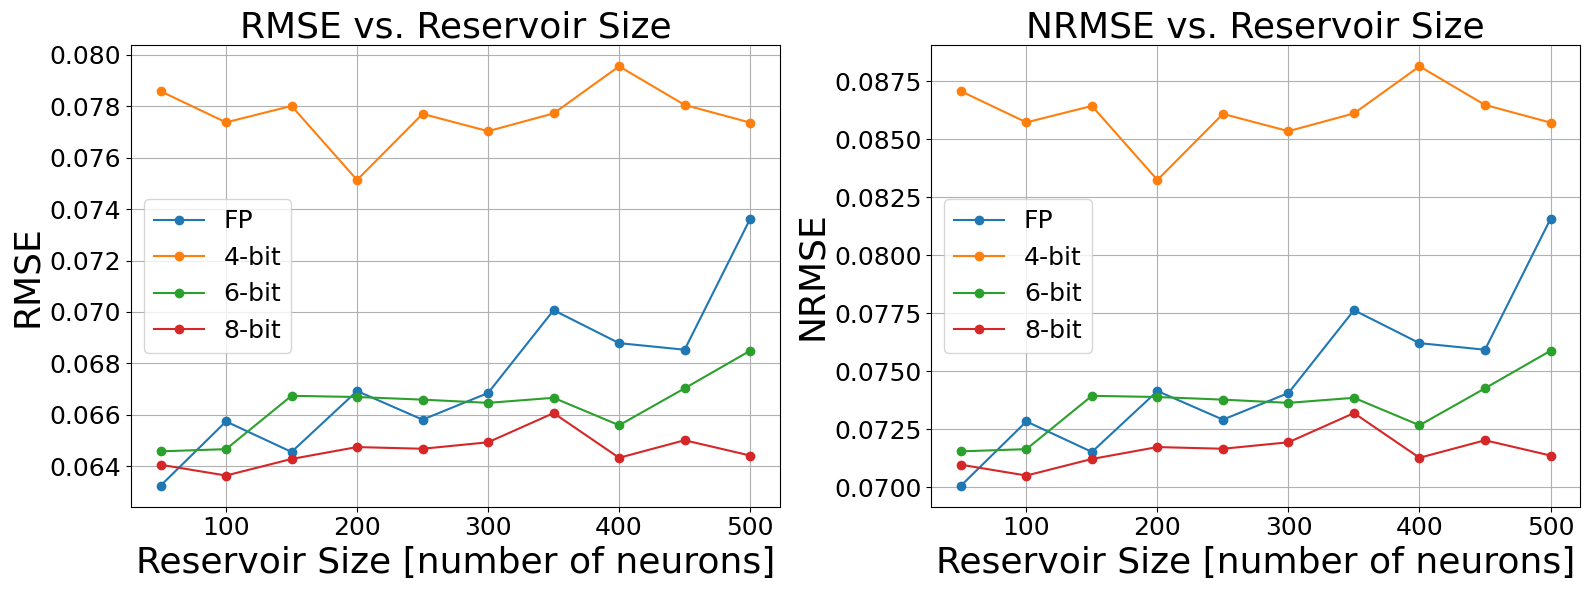

In [5]:
import matplotlib.pyplot as plt

metrics = ['RMSE', 'NRMSE']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    for bits in ['FP', 4, 6, 8]:
        subset = df_results[df_results['bits'] == bits]
        # only add "-bit" suffix for the numeric entries
        if bits == 'FP':
            label = 'FP'
        else:
            label = f"{bits}-bit"
        ax.plot(subset['N'], subset[metric], marker='o', label=label)

    ax.set_title(f"{metric} vs. Reservoir Size", fontsize=26)
    ax.set_xlabel("Reservoir Size [number of neurons]", fontsize=26)
    ax.set_ylabel(metric, fontsize=26)
    ax.tick_params(axis='both', labelsize=18)
    ax.grid(True)
    ax.legend(fontsize=18)

plt.tight_layout()
plt.savefig("sunspot.pdf", bbox_inches='tight')
plt.show()


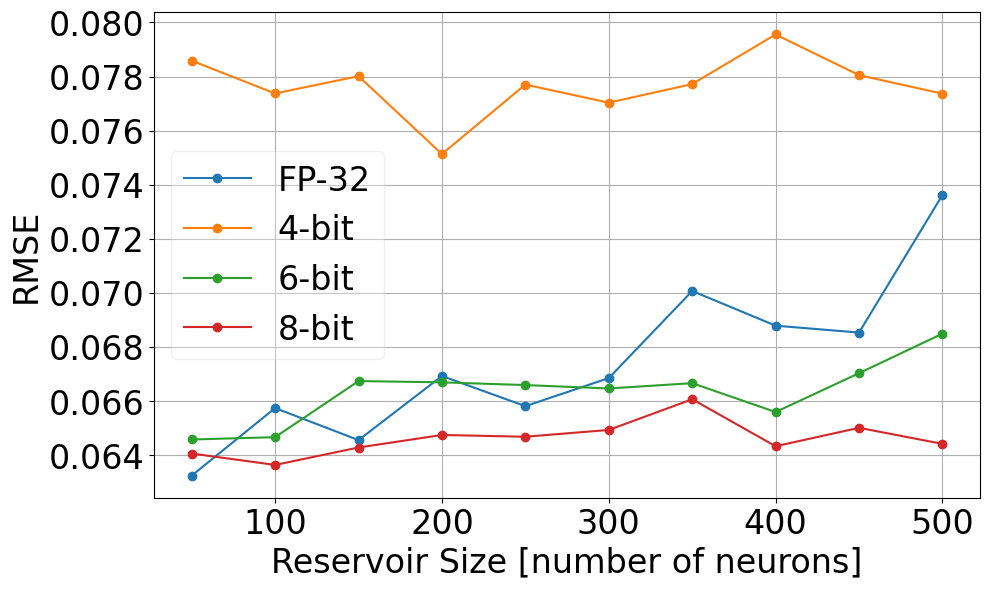

In [6]:
#last 30 August 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for bits in ['FP', 4, 6, 8]:
    subset = df_results[df_results['bits'] == bits]
    label = 'FP-32' if bits == 'FP' else f"{bits}-bit"
    plt.plot(subset['N'], subset['RMSE'], marker='o', label=label)

plt.xlabel("Reservoir Size [number of neurons]", fontsize=24)
plt.ylabel("RMSE", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True)
plt.tight_layout()

# Transparent legend and more space from top
plt.legend(fontsize=24, framealpha=0.3, loc='best')

plt.savefig("sunspot.pdf", bbox_inches='tight')
plt.show()

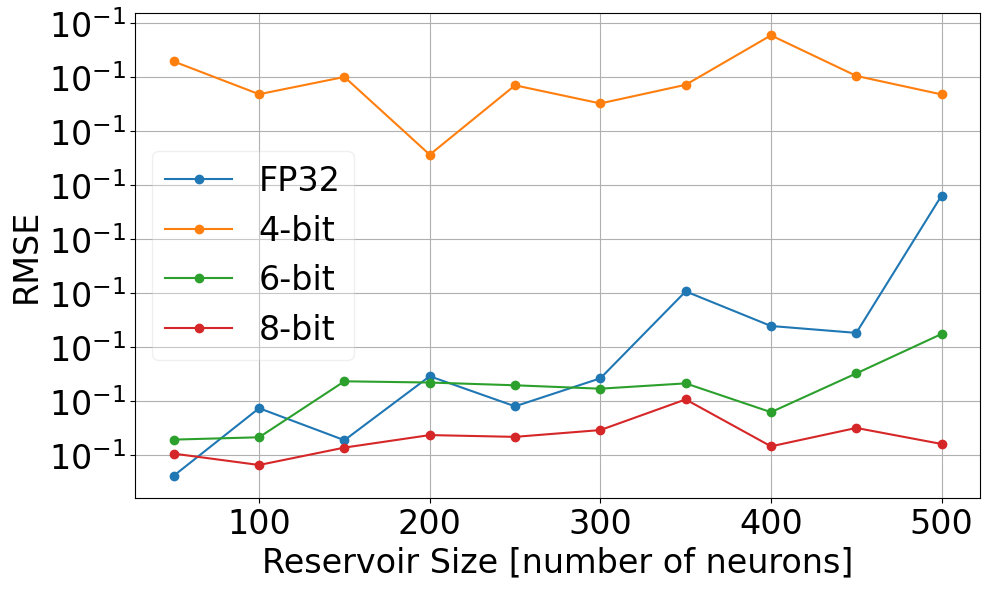

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
plt.figure(figsize=(10, 6))
for bits in ['FP', 4, 6, 8]:
    subset = df_results[df_results['bits'] == bits]
    label = 'FP32' if bits == 'FP' else f"{bits}-bit"
    plt.plot(subset['N'], subset['RMSE'], marker='o', label=label)

plt.xlabel("Reservoir Size [number of neurons]", fontsize=24)
plt.ylabel("RMSE", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Force y-axis ticks as powers of 10
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$" if x > 0 else "0"))

plt.grid(True)
plt.tight_layout()

# Transparent legend and more space from top
plt.legend(fontsize=24, framealpha=0.3, loc='best')

plt.savefig("sunspot.pdf", bbox_inches='tight')
plt.show()


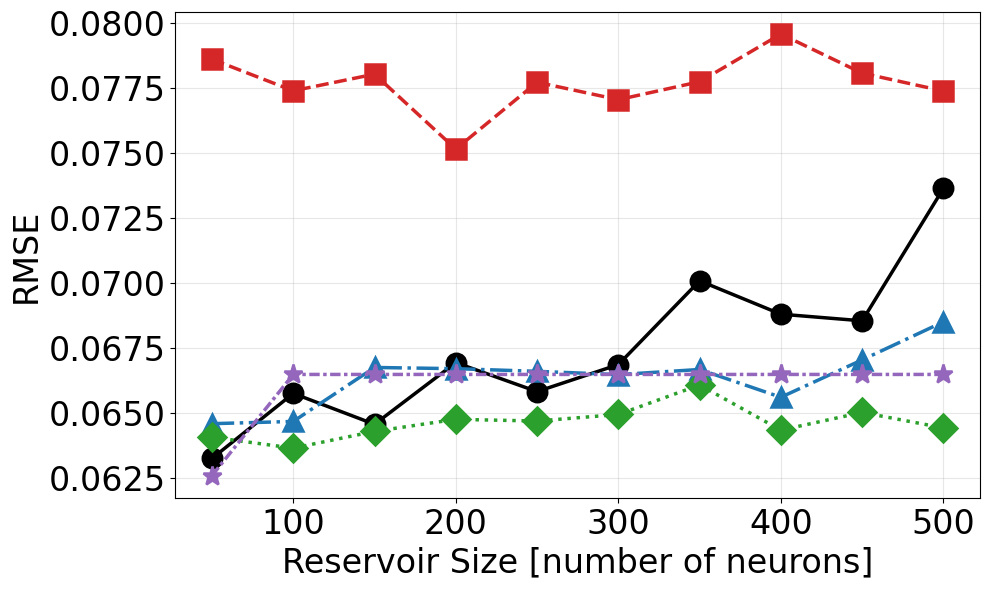

In [8]:
import matplotlib.pyplot as plt

# Define styles
styles = {
    'FP':  dict(color='black',      linestyle='-',  marker='o'),
    4:     dict(color='tab:red',    linestyle='--', marker='s'),
    6:     dict(color='tab:blue',   linestyle='-.', marker='^'),
    8:     dict(color='tab:green',  linestyle=':',  marker='D'),
    16:    dict(color='tab:purple', linestyle=(0, (3, 1, 1, 1)), marker='*')
}

plt.figure(figsize=(10, 6))

for bits in ['FP', 4, 6, 8, 16]:
    subset = df_results[df_results['bits'] == bits]
    label = 'FP-32' if bits == 'FP' else f"{bits}-bit"

    plt.plot(
        subset['N'],
        subset['RMSE'],
        label=label,
        linewidth=2.5,
        markersize=14,          # bigger markers
        markeredgewidth=1.8,    # thicker marker border

        **styles[bits]
    )

plt.xlabel("Reservoir Size [number of neurons]", fontsize=24)
plt.ylabel("RMSE", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("sunspot_R.pdf", bbox_inches='tight')
plt.show()


In [9]:
print("R\u00B2")

R²
